# All-CNN-C & Centered Kernel Alignment in JAX
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/code-and-blog/blob/main/10_all_cnn_cka/cka.ipynb)

<a href="https://github.com/RobertTLange/code-and-blog/blob/main/10_all_cnn_cka/linear_depth_1.gif?raw=true"><img src="https://github.com/RobertTLange/code-and-blog/blob/main/10_all_cnn_cka/linear_depth_1.gif?raw=true" width="400" align="right" /></a>
In this notebook we implement the Centered Kernel Alignment (CKA) metric used to compare the representations of different neural network layers for the same or two separate networks. CKA measures the similarity of representations at different network layers of the same or different networks. It has the advantage of being invariant to orthogonal transformations (e.g. neuron permutation) and to isotropic scaling. 

In the following we will consider All-CNN-C [(Springenberg et al., 2015)](https://arxiv.org/abs/1412.6806) networks trained on CIFAR-10 (see `train_cifar10.py`) and compare activations across layers within a single network, across different architectures plus different training stages and for different class representations. Thereby, we will reproduce figure 3 of [Kornblith et al. (2019)](https://arxiv.org/abs/1905.00414) and try to obtain a deeper understanding for how these representations arise throughout training. The animation on the right-hand side shows the CKA of the final network checkpoint after 350 training epochs (x-axis) compared to its intermediate checkpoints (y-axis). Note that there is a lot of initial shuffling at the beginning of training and that the anti-diagonal elements of the matrix converge to 1. 

The training loop and the CKA computation are all implemented using a combination of JAX/flax/optax which allows us to speed up the computation for the different layers via jit-compilation and acceleration. The training stats and network checkpoint logging relies on my own [`mle-logging`](https://github.com/RobertTLange/mle-logging) package. Throughout the blog we will assume that we have access to trained networks which we can query to obtain lists of layer-wise activations. If you are more interested in learning how to train networks using flax, I recommend checking out the [code base]() and my [All-CNN-C]() implementation. Let's now have a closer look at how to use CKA to analyse neural network representations:

# Setup & Checkpoint Cloning

Let's start by cloning the repository and downloading the CIFAR-10 network checkpoints. You can alternatively also train the networks yourself but this will take a couple of hours on a 2080Ti. The All-CNN architecture stacks Conv-BatchNorm-ReLU blocks and replaces all MaxPool operations with larger strides. There are no linear layers and the readout is computed using global average pooling. The training protocol is fairly straight forward and largely follows the hyperparameters outlined by [Springenberg et al. (2015)](https://arxiv.org/abs/1412.6806) and some details presented in the supplementary material of [Kornblith et al. (2019)](https://arxiv.org/abs/1905.00414). For the two considered depths these include the following:

- Training amount: 350 epochs, 128 batchsize
- Learning rate 0.1, momentum: 0.9, L2 weight decay: 0.001
- Learning rate decay: After [200, 250, 300] epochs decreased by 0.1 multiplication
- Augmentation: Random Crops, Random Horizontal Flips, Normalization, Cutout
  - v1: Input image dropout (20%), after each (2,2) stride layer replacing maxpool (50%)
  - v2: No dropout applied

Interestingly and unlike recommended from the original implementation, dropout appears to hurt performance. Using v2 without any dropout, we consistently get the desired ~94% test accuracy. Afterwards, we install all the needed dependencies:

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Clone the code repository
!git clone https://github.com/RobertTLange/code-and-blog
%cd code-and-blog/10_all_cnn_cka
# Download checkpoints from GCS bucket. This can take a minute.
!gsutil -m -q cp -r gs://jax-snippets/experiments/ .

!pip install -r requirements.txt -q
!ls experiments

In [ ]:
import jax
import jax.numpy as jnp 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


# How to Compute Centered Kernel Alignment

The CKA score was introduced by [Kornblith et al. (2019)](https://arxiv.org/abs/1905.00414) and is defined as follows:

$$\texttt{CKA}(\mathbf{K}, \mathbf{L}) = \frac{\texttt{HSIC}(\mathbf{K}, \mathbf{L})}{\sqrt{\texttt{HSIC}(\mathbf{K}, \mathbf{K})\texttt{HSIC}(\mathbf{L}, \mathbf{L})}}$$

with $\texttt{HSIC}$ denoting the Hilbert-Schmidt independence criterion:

$$\texttt{HSIC}(\mathbf{K}, \mathbf{L}) = \frac{\text{tr}(\mathbf{K} \mathbf{H}_m \mathbf{L} \mathbf{H}_m)}{(m-1)^2},$$

with $\mathbf{H}_m = \mathbf{I}_m - \frac{1}{m} \mathbf{1}\mathbf{1}^T$. In linear CKA $\mathbf{K} = \mathbf{X}\mathbf{X}^T, \mathbf{L} = \mathbf{Y}\mathbf{Y}^T$ denote the Gram matrices, where $\mathbf{X} \in \mathbb{R}^{m \times p_1}, \mathbf{Y} \in \mathbb{R}^{m \times p_2}$ denote the matrices of network layer activations ($m$ examples, $p_1/p_2$ neurons). Importantly, CKA does not dependent on $p_1 = p_2$, and hence the number of neurons in one layer of a network can be different from the other layer we compare it to. $\texttt{HSIC}$ is usually estimated using batches of input samples and their resulting activations. There are many cool equivalence relationship related to information theory and concepts from statistical independence you can read up on in the original paper.
Another formulation of CKA is based on Radial Basis Functions (RBF). In this case $\mathbf{K}, \mathbf{L}$ are computed using a kernel  $k(x_i, x_j ) = \exp\left(\frac{−||x_i −x_j||_2^2}{2\sigma^2}\right)$ for a chosen width $\sigma$. In practice the resulting representational similarity scores don't significantly change when switching from a linear to a RBF kernel. Now let's implement CKA:


In [ ]:
def CKA(X, Y, kernel="linear", sigma_frac=0.4):
    """Centered Kernel Alignment."""
    if kernel == "linear":
        K, L = linear_kernel(X, Y)
    elif kernel == "rbf":
        K, L = rbf_kernel(X, Y, sigma_frac)
    return HSIC(K, L)/jnp.sqrt(HSIC(K, K) * HSIC(L, L))


@jax.jit
def linear_kernel(X, Y):
    K = X @ X.T
    L = Y @ Y.T
    return K, L


@jax.jit
def rbf_kernel(X, Y, sigma_frac=0.4):
    """ Compute radial basis function kernels. """
    # Define helper for euclidean distance
    def euclidean_dist_matrix(X, Y):
        """ Compute matrix of pairwise, squared Euclidean distances. """
        norms_1 = (X ** 2).sum(axis=1)
        norms_2 = (Y ** 2).sum(axis=1)
        return jnp.abs(norms_1.reshape(-1, 1) + norms_2 - 2 * jnp.dot(X, Y.T))
    
    # Define σ as a fraction of the median distance between examples
    dist_X = euclidean_dist_matrix(X, X)
    dist_Y = euclidean_dist_matrix(Y, Y)
    sigma_x = sigma_frac*jnp.percentile(dist_X, 0.5)
    sigma_y = sigma_frac*jnp.percentile(dist_Y, 0.5)
    K = jnp.exp(-dist_X/(2*sigma_x**2))
    L = jnp.exp(-dist_Y/(2*sigma_y**2))
    return K, L


@jax.jit
def HSIC(K, L):
    """Hilbert-Schmidt Independence Criterion."""
    m = K.shape[0]
    H = jnp.eye(m) - 1/m * jnp.ones((m, m))
    numerator = jnp.trace(K @ H @ L @ H)
    return numerator / (m - 1)**2

`CKA` takes as an input the activations of two network layers and outputs a scalar. This can be activations/representations from the same network or from different networks. If we want to obtain a nice matrix of pairwise CKA scores, we need to perform this computation for all pairs of layers. And obviously we need a nice plotting helper:

In [ ]:
def get_cka_matrix(activations_1, activations_2, kernel="linear", sigma_frac=0.4):
    """ Loop over layer combinations & construct CKA matrix."""
    num_layers_1 = len(activations_1)
    num_layers_2 = len(activations_2)
    cka_matrix = np.zeros((num_layers_1, num_layers_2))
    symmetric = num_layers_1 == num_layers_2

    # TODO: In principle we should be able to vectorize/vmap/pmap this loop!
    for i in range(num_layers_1):
        if symmetric:
            for j in range(i, num_layers_2):
                X, Y = activations_1[i], activations_2[j]
                cka_temp = CKA(X, Y, kernel, sigma_frac)
                cka_matrix[num_layers_1-i-1, j] = cka_temp
                cka_matrix[i, num_layers_1-j-1] = cka_temp
        else:
            for j in range(num_layers_2):
                X, Y = activations_1[i], activations_2[j]
                cka_temp = CKA(X, Y, kernel, sigma_frac)
                cka_matrix[num_layers_1-i-1, j] = cka_temp
    return cka_matrix


def plot_cka_matrix(cka_matrix, title="All-CNN-C",
                    xlabel="Layer ID", ylabel="Layer ID",
                    every_nth_tick=1, ax=None, fig=None):
    """" Helper Function for Plotting CKA Matrices. """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    im = ax.imshow(cka_matrix, vmin=0, vmax=1)
    
    yticklabels = list(reversed(["L" + str(i+1) for i 
                                 in range(cka_matrix.shape[0])]))
    ax.set_yticks(np.arange(len(yticklabels)))
    ax.set_yticklabels(yticklabels, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=14)

    for n, label in enumerate(ax.yaxis.get_ticklabels()):
        if n % every_nth_tick != 0:
            label.set_visible(False)

    xticklabels = ["L" + str(i+1) for i in range(cka_matrix.shape[1])]
    ax.set_xticks(np.arange(len(xticklabels)))
    ax.set_xticklabels(xticklabels, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=14)

    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth_tick != 0:
            label.set_visible(False)
    ax.set_title(title, fontsize=16)
    plt.setp(ax.get_xticklabels(), rotation=75, ha="right", rotation_mode="anchor")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.15)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label("CKA Score", rotation=270, labelpad=30, fontsize=18)
    cbar.ax.tick_params(labelsize=14)
    fig.tight_layout()

# Representational Structure of Final All-CNN-C Checkpoint

We are now ready to have a closer look at the All-CNN-C CIFAR-10 trained network checkpoints. We start by loading the log of training statistics using the [`mle-logging`](https://github.com/RobertTLange/mle-logging) log and plot the performance throughout training:

Text(0.5, 14.5, 'Number of Epochs')

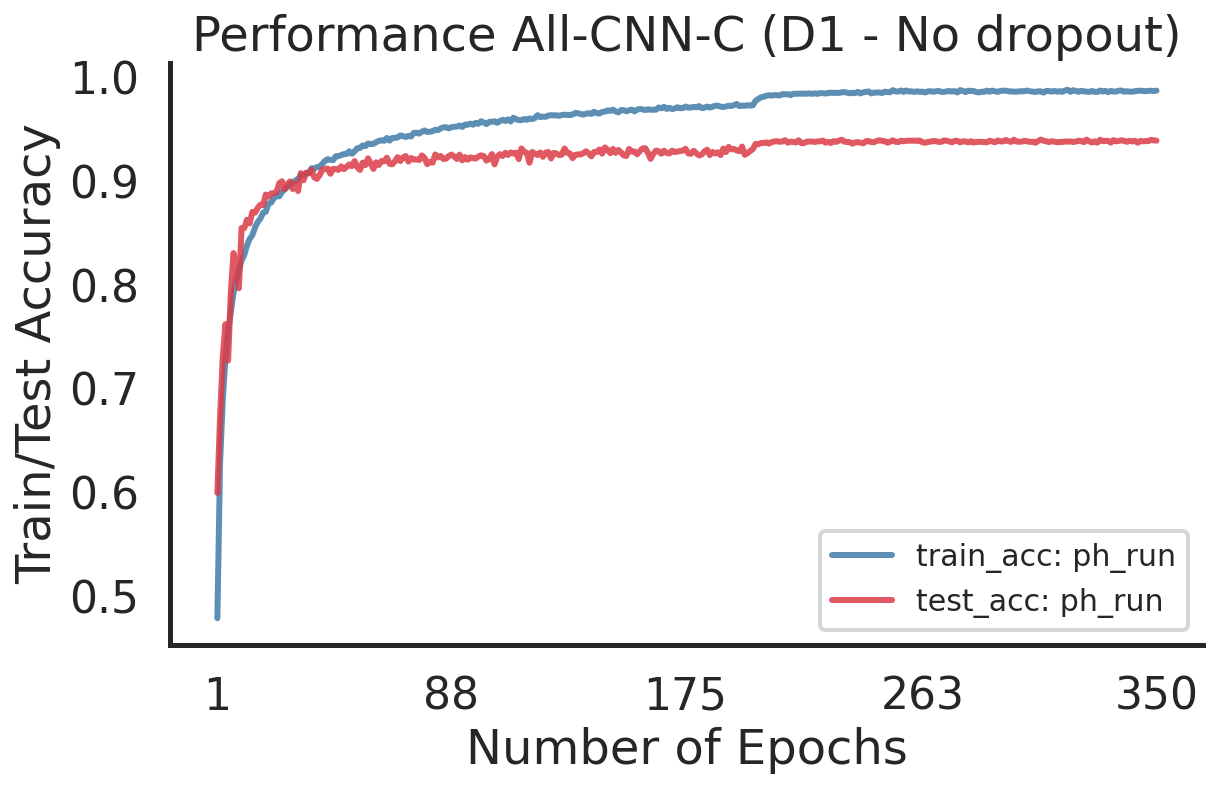

In [ ]:
from mle_logging import load_log, load_model

log_s0 = load_log("experiments/all_cnn_depth_1_v2_seed_0/")
log_s1 = load_log("experiments/all_cnn_depth_1_v2_seed_1/")

fig, ax = log_s0.plot(["train_acc", "test_acc"], "num_epochs")
ax.set_title("Performance All-CNN-C (D1 - No dropout)")
ax.set_ylabel("Train/Test Accuracy")
ax.set_xlabel("Number of Epochs")

The All-CNN-C network trains to ca. 93% test accuracy and we can observe a nice little kink in accuracy after the first learning rate decrease in epoch 200. Next up we load the network weights and the CIFAR-10 dataloader to extract a set of layerwise features for a large batch of training samples (Note: Here and for convenience we only use a single batch to estimate the CKA score):

In [ ]:
from train.models import All_CNN_C_Features
from train.utils import get_dataloaders

# Get CIFAR-10 dataloader
train_loader, test_loader = get_dataloaders(1028)

# Get batch activations
for batch_idx, (data, target) in enumerate(train_loader):
    batch_images = jnp.array(data)
    batch_labels = jnp.array(target)
    break

# Reload the trained final checkpoint
cnn_depth_1_s0 = load_model(log_s0.meta.model_ckpt, model_type="jax")
cnn_depth_1_s1 = load_model(log_s1.meta.model_ckpt, model_type="jax")

print(cnn_depth_1_s0["params"].unfreeze().keys())

loaded_model = All_CNN_C_Features(**log_s0.meta.config_dict["model_config"])
activations_s0 = loaded_model.apply(cnn_depth_1_s0, batch_images, train=False)
activations_s1 = loaded_model.apply(cnn_depth_1_s1, batch_images, train=False)

Files already downloaded and verified
Files already downloaded and verified
dict_keys(['BatchNorm_0', 'BatchNorm_1', 'BatchNorm_2', 'BatchNorm_3', 'BatchNorm_4', 'BatchNorm_5', 'BatchNorm_6', 'BatchNorm_7', 'BatchNorm_8', 'Conv_0', 'Conv_1', 'Conv_2', 'Conv_3', 'Conv_4', 'Conv_5', 'Conv_6', 'Conv_7', 'Conv_8'])


Next we compute the linear CKA scores for the list of activations and visualize them. A simple sanity check is to compare representations resulting from the same model trained based on different random seeds. In this case we can expect that the anti-diagonal elements are the most similar and indeed this is the case.

From the plots we can observe also that the elements close to the anti-diagonal are close but different from 1. This indicates a division of labor where each layer contributes to the decision readout that emerges throughout the network. In larger networks for example it can happen that additional layers in a block don't significantly transform the representations. In this case one can expect to observe a stronger block structure.

In [ ]:
# Compute pairwise (layer combinations) CKA score & plot them
linear_cka_matrix = get_cka_matrix(activations_s0, activations_s0, "linear")
rbf_cka_matrix = get_cka_matrix(activations_s0, activations_s0, "rbf", sigma_frac=0.09)
seeds_cka_matrix = get_cka_matrix(activations_s0, activations_s1, "linear")
del activations_s1

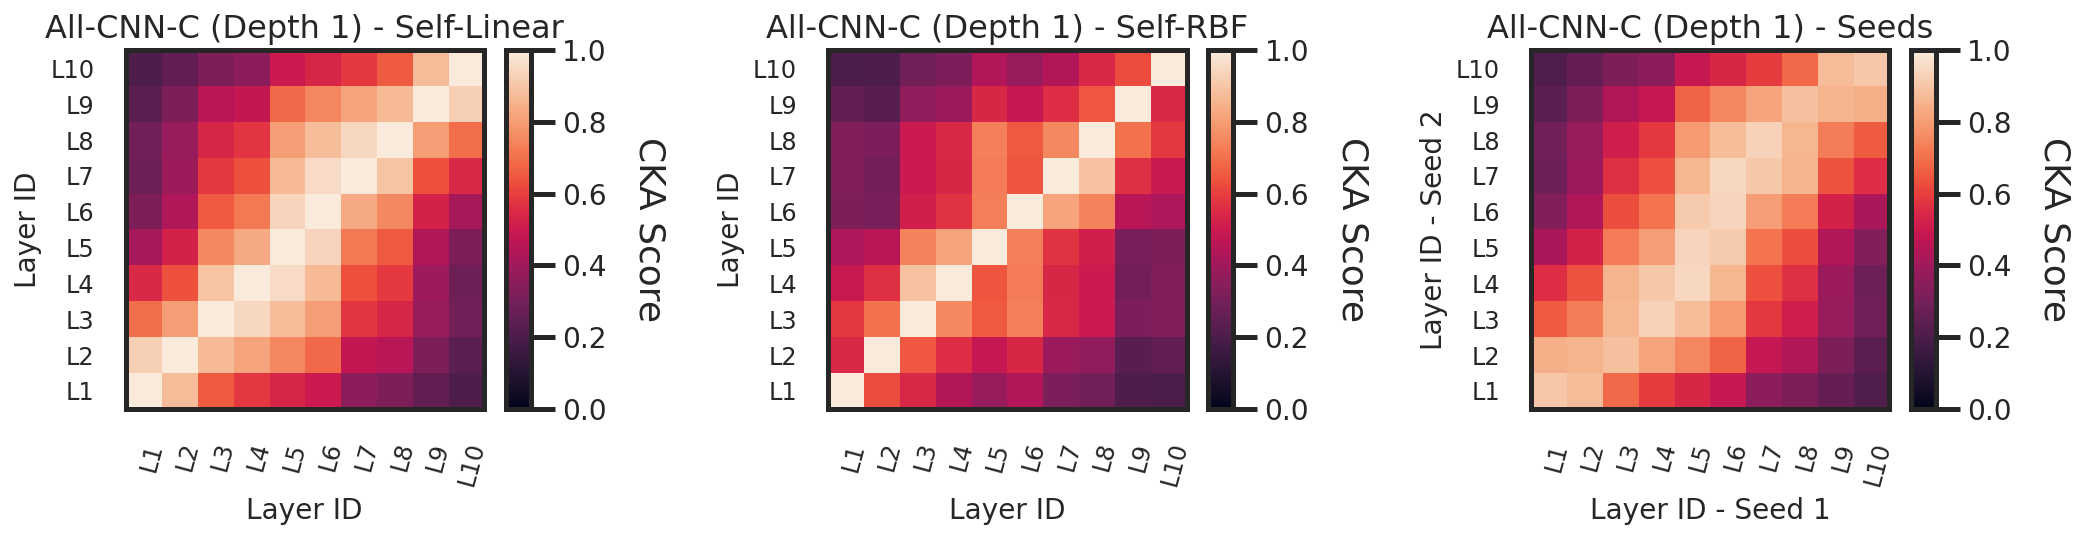

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
plot_cka_matrix(linear_cka_matrix, ax=axs[0], fig=fig, title="All-CNN-C (Depth 1) - Self-Linear")
plot_cka_matrix(rbf_cka_matrix, ax=axs[1], fig=fig, title="All-CNN-C (Depth 1) - Self-RBF")
plot_cka_matrix(seeds_cka_matrix, ax=axs[2], fig=fig, title="All-CNN-C (Depth 1) - Seeds",
                xlabel="Layer ID - Seed 1", ylabel="Layer ID - Seed 2")

# Emergence of Representational Structure over Training

Next let's examine how the representational similarity of a network changes throughout training and compared to its representations based on the final checkpoint after 350 epochs. We loop over a set of model checkpoints and visualize the scores for the different training snapshots. As expected we can see that the self-similarity structure emerges throughout training and that the initial epochs cover the most ground:

In [ ]:
# Here is the init/final checkpoint for reloading
print(log_s0.meta.init_ckpt)
print(log_s0.meta.model_ckpt)
# And here you find all previous checkpoint paths
ckpt_list = [log_s0.meta.init_ckpt]
labels = ["Init"]
for idx in [0, 4, 19, 29, 69]:
    ckpt_list.append(log_s0.meta.every_k_ckpt_list[idx])
    labels.append(log_s0.meta.every_k_storage_time[idx])
print(ckpt_list)

all_cka_matrices = []

for ckpt_path in ckpt_list:
    cnn_vars = load_model(ckpt_path, model_type="jax")
    loaded_model = All_CNN_C_Features(**log_s0.meta.config_dict["model_config"])
    activations_ckpt = loaded_model.apply(cnn_vars, batch_images, train=False)
    cka_matrix = get_cka_matrix(activations_ckpt, activations_s0)
    all_cka_matrices.append(cka_matrix)
    print(f"Completed: {ckpt_path}")

del activations_ckpt

experiments/all_cnn_depth_1_v2_seed_0/models/init/init_seed_0.pkl
experiments/all_cnn_depth_1_v2_seed_0/models/final/final_seed_0.pkl
['experiments/all_cnn_depth_1_v2_seed_0/models/init/init_seed_0.pkl', 'experiments/all_cnn_depth_1_v2_seed_0/models/every_k/every_k_seed_0_k_5.pkl', 'experiments/all_cnn_depth_1_v2_seed_0/models/every_k/every_k_seed_0_k_25.pkl', 'experiments/all_cnn_depth_1_v2_seed_0/models/every_k/every_k_seed_0_k_100.pkl', 'experiments/all_cnn_depth_1_v2_seed_0/models/every_k/every_k_seed_0_k_150.pkl', 'experiments/all_cnn_depth_1_v2_seed_0/models/every_k/every_k_seed_0_k_350.pkl']
Completed: experiments/all_cnn_depth_1_v2_seed_0/models/init/init_seed_0.pkl
Completed: experiments/all_cnn_depth_1_v2_seed_0/models/every_k/every_k_seed_0_k_5.pkl
Completed: experiments/all_cnn_depth_1_v2_seed_0/models/every_k/every_k_seed_0_k_25.pkl
Completed: experiments/all_cnn_depth_1_v2_seed_0/models/every_k/every_k_seed_0_k_100.pkl
Completed: experiments/all_cnn_depth_1_v2_seed_0/mode

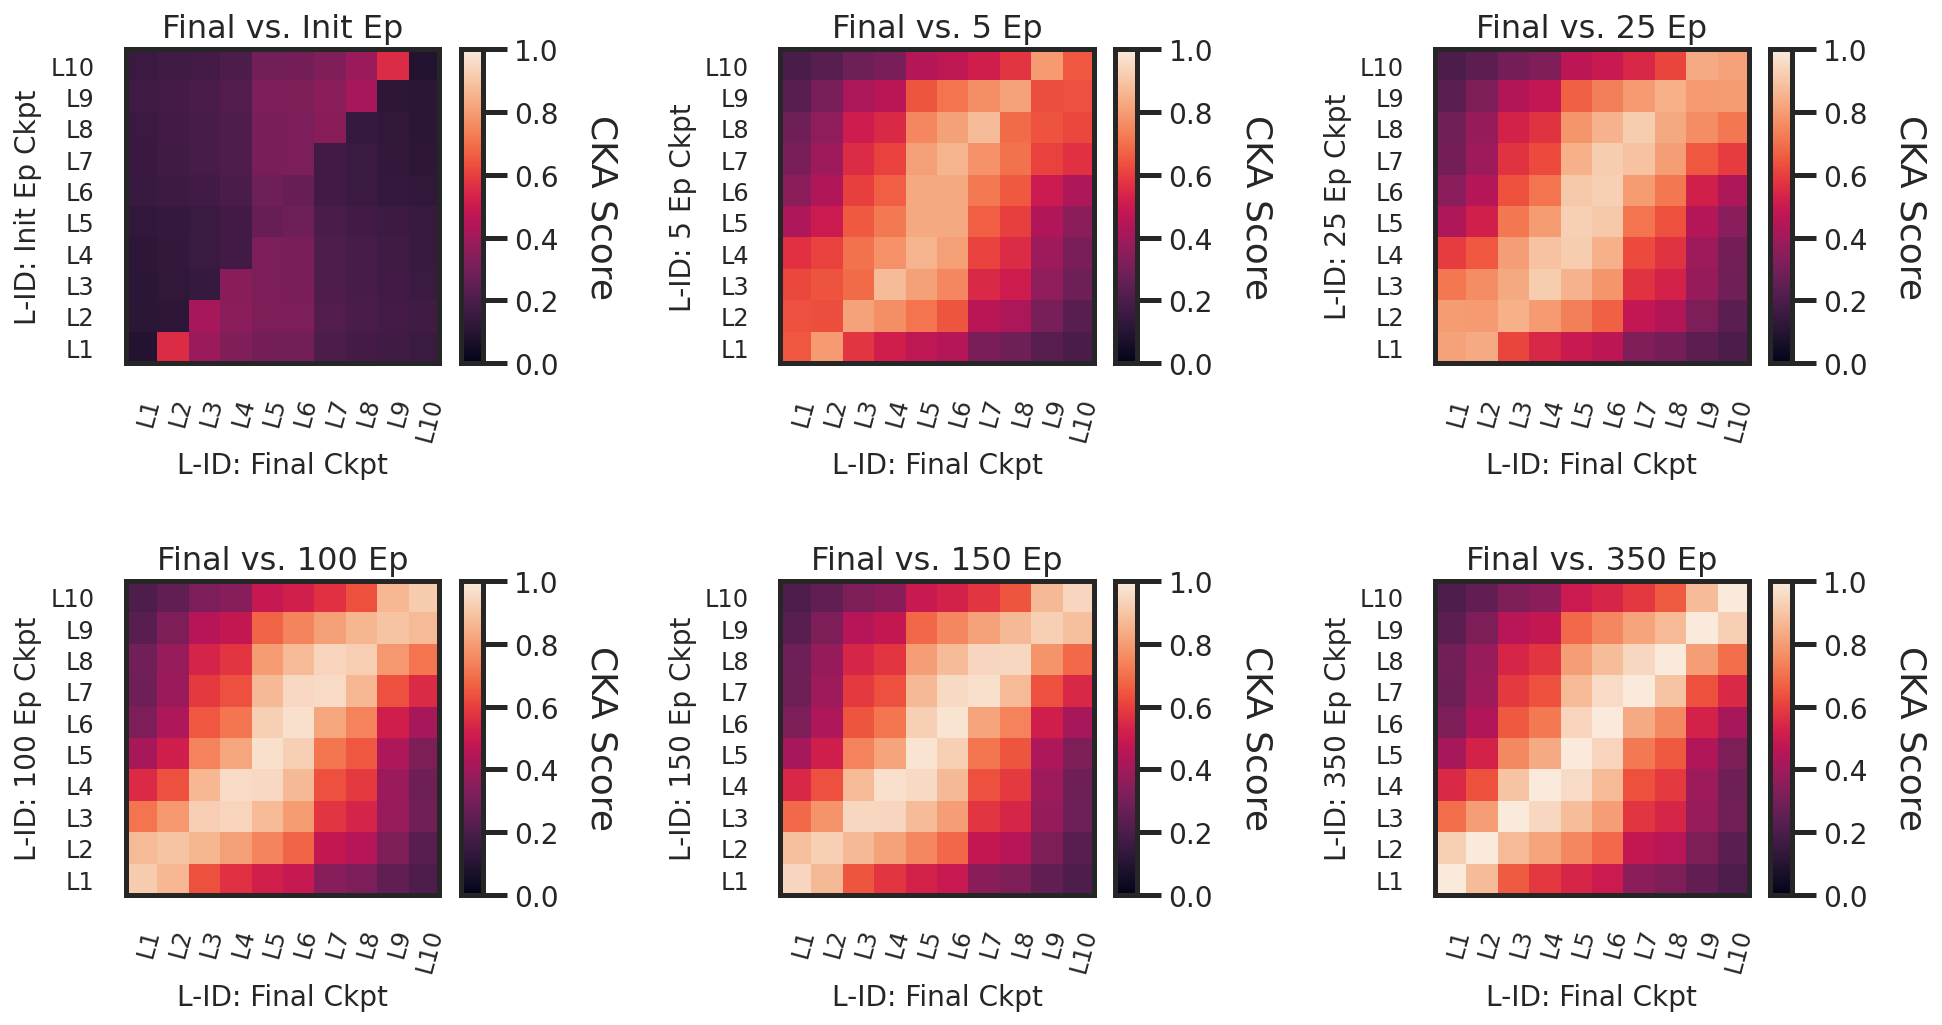

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
for i in range(6):
    ckpt_time = labels[i]
    plot_cka_matrix(all_cka_matrices[i], title=f"Final vs. {ckpt_time} Ep",
                    ylabel=f"L-ID: {ckpt_time} Ep Ckpt", xlabel="L-ID: Final Ckpt",
                    ax=axs.flatten()[i], fig=fig)
fig.tight_layout()

# Comparing Different Network Architectures

We have already seen that we can use CKA to compare representations of two different networks with the same number of layers (e.g. different seeds). But having the same number of layers is not a necessity. Next we will look at a deeper version of the All-CNN-C architecture and compare its representations with the "shallow" version. The "depth  2" version almost doubles the number of Conv-BatchNorm-ReLU blocks and in the plot below you can again see the learning curves:

Text(0.5, 14.5, 'Number of Epochs')

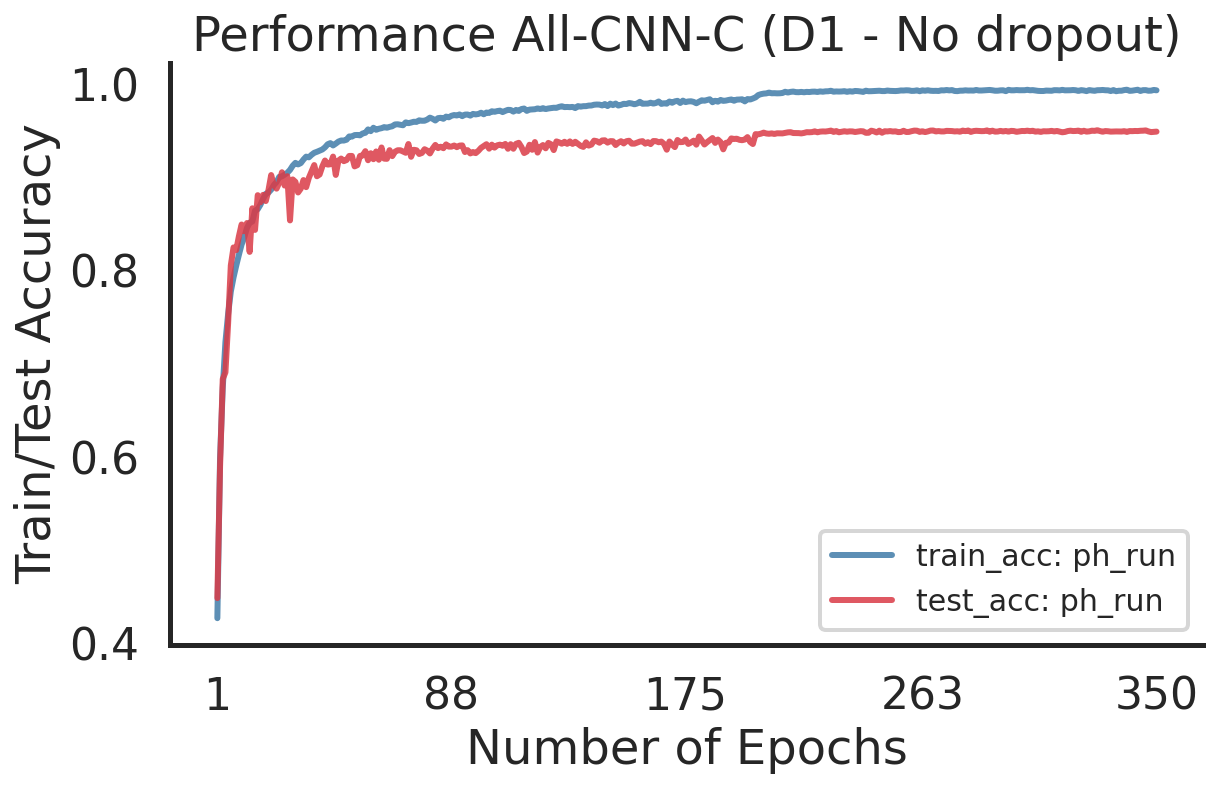

In [ ]:
log = load_log("experiments/all_cnn_depth_2_v2/")
fig, ax = log.plot(["train_acc", "test_acc"], "num_epochs")
ax.set_title("Performance All-CNN-C (D1 - No dropout)")
ax.set_ylabel("Train/Test Accuracy")
ax.set_xlabel("Number of Epochs")

For the "self-similarity" CKA plot we can now observe a lot more redundancy. There are approximately 3 blocks within the representaion changes "little". When comparing the two different architectures, on the other hand, the representations towards the end of the processing appear fairly different.

In [ ]:
# Reload the trained final checkpoint & get the representations
cnn_vars = load_model(log.meta.model_ckpt, model_type="jax")
loaded_model = All_CNN_C_Features(**log.meta.config_dict["model_config"])
activations_deep = loaded_model.apply(cnn_vars, batch_images, train=False)

# Compute the CKA matrices
self_cka_matrix = get_cka_matrix(activations_deep, activations_deep)
cka_matrix = get_cka_matrix(activations_deep, activations_s0)

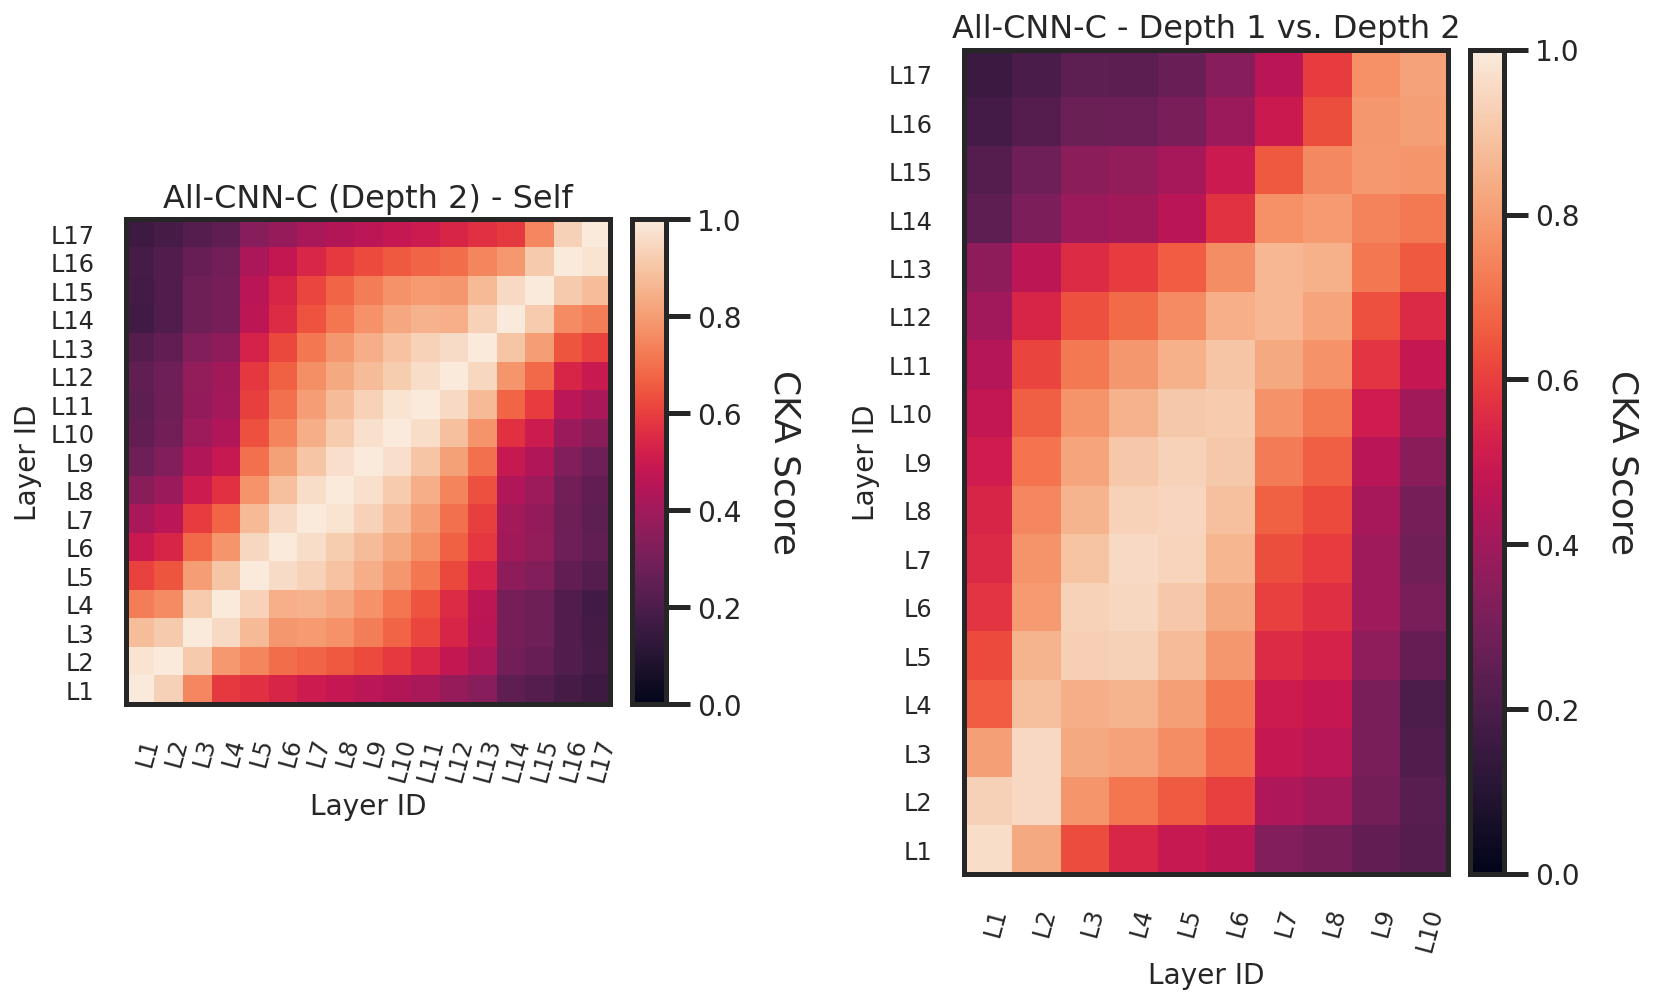

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))
plot_cka_matrix(self_cka_matrix, title="All-CNN-C (Depth 2) - Self", ax=axs[0], fig=fig)
plot_cka_matrix(cka_matrix, title="All-CNN-C - Depth 1 vs. Depth 2", ax=axs[1], fig=fig)
fig.tight_layout()

# CKA Invariance to Orthogonal Trafos & Isotropic Scaling

Finally, we quickly check some of the nice invariance properties of CKA: First, the CKA score should not change if we permute activation neurons. Second, the CKA score should not change if we rescale one of the representations with a constant factor.

In [ ]:
# Swap columns of activation matrices
permuted_neuron_idx = np.random.permutation(activations_deep[0].shape[1])
layer_act_0 = np.array(activations_deep[1])[:, permuted_neuron_idx]

cka_raw = CKA(activations_deep[1], activations_deep[3], kernel="linear")
cka_perm = CKA(layer_act_0, activations_deep[3], kernel="linear")
np.isclose(cka_raw, cka_perm, rtol=1e-04)

True

In [ ]:
# Scale one of the activations by a constant
cka_up = CKA(0.5*layer_act_0, activations_deep[3], kernel="linear")
cka_down = CKA(3*layer_act_0, activations_deep[3], kernel="linear")
np.isclose(cka_up, cka_raw, rtol=1e-05), np.isclose(cka_down, cka_raw, rtol=1e-04)

(True, True)

# CKA for Vision Transformers & Where to go from here

If you want to learn more about CKA and the representations of Vision Transformers compared to standard ResNet architectures check out the recent preprint by [Raghu et al. (2021)](arxiv.org/abs/2108.08810) and my [ML-Collage](https://twitter.com/hashtag/mlcollage?src=hashtag_click) poster summary. If you are interested in performing the same analysis for a ViT model, I would recommend starting by checking out the official [Vision Transformer](https://github.com/google-research/vision_transformer) repository and to write a helper function to extract the representrations. Finally, there are many more measures one can compute to compare different representations. These include SVCCA, PWCCA and a good NumPy implementation can be found in this [repository](https://github.com/google/svcca).

![](https://pbs.twimg.com/media/E-XswtYWEBQ9UqI?format=jpg&name=4096x4096)
